## Imports

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

## Read and display data

In [2]:
path_a = Path('b_small.in')

In [3]:
with path_a.open(mode='r') as f:
    params = f.readline().replace('\n', '').split(' ')
    rows = int(params[0])
    cols = int(params[1])
    min_ing = int(params[2])
    max_cel = int(params[3])
    lines = []
    for line in f:
        row = []
        for char in line:
            if char == 'M':
                row.append(0)
            elif char == 'T':
                row.append(1)
        lines.append(row)

In [4]:
print('Rows:', rows)
print('Cols:', cols)
print('Min ingredient:', min_ing)
print('Max cells:', max_cel)
pizza = np.array(lines)
print(pizza)

Rows: 6
Cols: 7
Min ingredient: 1
Max cells: 5
[[1 0 0 0 1 1 1]
 [0 0 0 0 1 0 0]
 [1 1 0 1 1 0 1]
 [1 0 0 1 0 0 0]
 [1 1 1 1 1 1 0]
 [1 1 1 1 1 1 0]]


## Lots of useful functions

In [5]:
def display_two(*arrs, cmaps):
    fig, axes = plt.subplots(1, len(arrs), figsize=(15,10))
    for ax, arr, cmap in zip(axes, arrs, cmaps):
        ax.imshow(arr, cmap=cmap)
        for (j,i),label in np.ndenumerate(arr):
            ax.text(i,j,f'{label:.2f}',ha='center',va='center', color='black')

In [6]:
def get_num_done(r1, c1, r2, c2):
    return np.sum(done[get_locs(r1, c1, r2, c2)] == 1)

In [7]:
def get_prog(r1, c1, r2, c2):
    count = get_count(r1, c1, r2, c2)
    return max(min_ing - count[0], 0) + max(min_ing - count[1], 0)

In [8]:
def large(r1, c1, r2, c2):
    size = get_size(r1, c1, r2, c2)
    if size < max_cel:
        return 0
    elif size == max_cel:
        return 1
    elif size > max_cel:
        return 2

In [9]:
def enough(r1, c1, r2, c2):
    count = get_count(r1, c1, r2, c2)
    return min(tuple(count.values())) >= min_ing

In [10]:
def increment(r1, c1, r2, c2, opt):
    if opt == 0:
        r1 -= 1 if r1 > 0 else 0
    elif opt == 1:
        c1 -= 1 if c1 > 0 else 0
    elif opt == 2:
        r2 += 1 if r2 < rows-1 else 0
    elif opt == 3:
        c2 += 1 if c2 < cols-1 else 0
    else:
        raise ValueError
        
    return r1, c1, r2, c2

In [11]:
def get_count(r1, c1, r2, c2):
    count={0: 0, 1: 0}
    locs = get_locs(r1, c1, r2, c2)
    for r, c in zip(locs[0], locs[1]):
        count[pizza[(r, c)]] += 1
        
    return count

In [12]:
def get_size(r1, c1, r2, c2):
    return (r2 + 1 - r1) * (c2 + 1 - c1)

In [13]:
def get_locs(r1, c1, r2, c2):
    rs = []
    cs = []
    for r in range(r1, r2+1):
        for c in range(c1, c2+1):
            rs.append(r)
            cs.append(c)
            
    return rs, cs

## Actualy doing things

In [14]:
def expand(r1, c1, r2, c2, fill=False):
    if enough(r1, c1, r2, c2) and not fill:
        return False
    if large(r1, c1, r2, c2):
        return False

    num_done = get_num_done(r1, c1, r2, c2)
    
    change = False
    best_improve = 0
    prog = get_prog(r1, c1, r2, c2)
    for opt in range(4):
        r1t, c1t, r2t, c2t = increment(r1, c1, r2, c2, opt)
        if large(r1t, c1t, r2t, c2t) == 2:
            continue
        if get_num_done(r1t, c1t, r2t, c2t) > num_done:
            continue
        if not change and (r1t, c1t, r2t, c2t) != (r1, c1, r2, c2):
            best = opt
            change = True
        
        count = get_count(r1t, c1t, r2t, c2t)
        improve = prog - get_prog(r1t, c1t, r2t, c2t)

        if improve > best_improve:
            best = opt
            change = True
            
    if change:
        r1, c1, r2, c2 = increment(r1, c1, r2, c2, best)
        return r1, c1, r2, c2
    else:
        return False

In [15]:
start = 0, 0, 0, 0
slices = {}
count = 0
done = np.zeros_like(pizza)
fill = False

while np.sum(done == 0) > 1:
    changed = False
    while True:
        res = expand(*start, fill)
        print(start, ' -> ', res)
        if res:
            print('Expanding')
            if enough(*res):
                slices[count] = res
                done[get_locs(*res)] = 1
                changed = True
                print('SLICE', res)
                start = res
            else:
                start = res
        else:
            count += 1
            print('Not expanding')
            break
    
    if changed:
        if not fill:
            print('Changes, no fill')
            not_done = np.where(done == 0)
            r, c = not_done[0][0], not_done[1][0]
            start = r, c, r, c
        else:
            print('Changes, YES fill')
            if count < len(slices):
                start = slices[count]
            else:
                print('Done')
                break
        
    elif not fill:
        print('Skip to FILL mode')
        fill = True
        count = 0
        start = slices[count]
    else:
        print('Done')
        break

(0, 0, 0, 0)  ->  (0, 0, 0, 1)
Expanding
SLICE (0, 0, 0, 1)
(0, 0, 0, 1)  ->  False
Not expanding
Changes, no fill
(0, 2, 0, 2)  ->  (0, 2, 1, 2)
Expanding
(0, 2, 1, 2)  ->  (0, 2, 2, 2)
Expanding
(0, 2, 2, 2)  ->  (0, 2, 3, 2)
Expanding
(0, 2, 3, 2)  ->  (0, 2, 4, 2)
Expanding
SLICE (0, 2, 4, 2)
(0, 2, 4, 2)  ->  False
Not expanding
Changes, no fill
(0, 3, 0, 3)  ->  (0, 3, 0, 4)
Expanding
SLICE (0, 3, 0, 4)
(0, 3, 0, 4)  ->  False
Not expanding
Changes, no fill
(0, 5, 0, 5)  ->  (0, 5, 1, 5)
Expanding
SLICE (0, 5, 1, 5)
(0, 5, 1, 5)  ->  False
Not expanding
Changes, no fill
(0, 6, 0, 6)  ->  (0, 6, 1, 6)
Expanding
SLICE (0, 6, 1, 6)
(0, 6, 1, 6)  ->  False
Not expanding
Changes, no fill
(1, 0, 1, 0)  ->  (1, 0, 2, 0)
Expanding
SLICE (1, 0, 2, 0)
(1, 0, 2, 0)  ->  False
Not expanding
Changes, no fill
(1, 1, 1, 1)  ->  (1, 1, 2, 1)
Expanding
SLICE (1, 1, 2, 1)
(1, 1, 2, 1)  ->  False
Not expanding
Changes, no fill
(1, 3, 1, 3)  ->  (1, 3, 1, 4)
Expanding
SLICE (1, 3, 1, 4)
(1, 3, 1, 4)

In [16]:
out = np.ones_like(pizza) * -1
for key, value in slices.items():
    locs = get_locs(*value)
    out[locs] = key

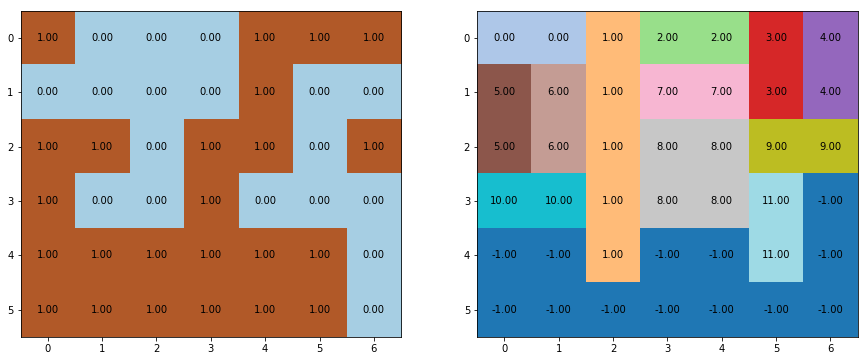

In [17]:
display_two(pizza, out, cmaps=['Paired', 'tab20'])